<a href="https://colab.research.google.com/github/w4bo/AA2425-unibo-bigdataandcloudplatforms/blob/main/slides/lab-01-Metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The `California Housing Pricing` case study

This notebook runs on Google Colab.

- Colab provides a serverless Jupyter notebook environment for interactive development.
- (At the moment, 2024) Google Colab is free to use like other G Suite products.

In this laboratory we will build a simple data pipeline to get acquainted with the "main" steps necessary to transform your data.

- The data contains information from the 1990 California census. It does provide an accessible introductory dataset for teaching people about the basics of machine learning. 

From the book [Hands on machine learning](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

> This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short. The goal is to build a model to predict the median housing price in any district, given all the other metrics.

# Setup (& library versioning)

First of all, we need to setup the Python environment by installing and importing the necessary Python dependencies.

In [2]:
!pip install prov pydot
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import prov

print(pd.__version__)
print(sk.__version__)
print(np.__version__)
print(sns.__version__)
print(prov.__version__)

2.2.3
1.5.2
2.0.2
0.13.2
2.0.1


Why should we track the libraries imported in the coding environment?

# Data collection

Import the dataset. In this case, there is no need for ETL/integration since the dataset is ready for elaboration.

In [4]:
df = pd.read_csv("https://w4bo.github.io/AA2324-unibo-bigdataandcloudplatforms/housing.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


# Profiling: Schema

In [5]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Schema description

1. `longitude`: A measure of how far west a house is; a higher value is farther west
2. `latitude`: A measure of how far north a house is; a higher value is farther north
3. `housingMedianAge`: Median age of a house within a block; a lower number is a newer building
4. `totalRooms`: Total number of rooms within a block
5. `totalBedrooms`: Total number of bedrooms within a block
6. `population`: Total number of people residing within a block
7. `households`: Total number of households, a group of people residing within a home unit, for a block
8. `medianIncome`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. `medianHouseValue`: Median house value for households within a block (measured in US Dollars)
10. `oceanProximity`: Location of the house w.r.t ocean/sea

# Profiling: Schema

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Profiling: Distribution and statistics

In [51]:
df.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


# Profiling: Distribution

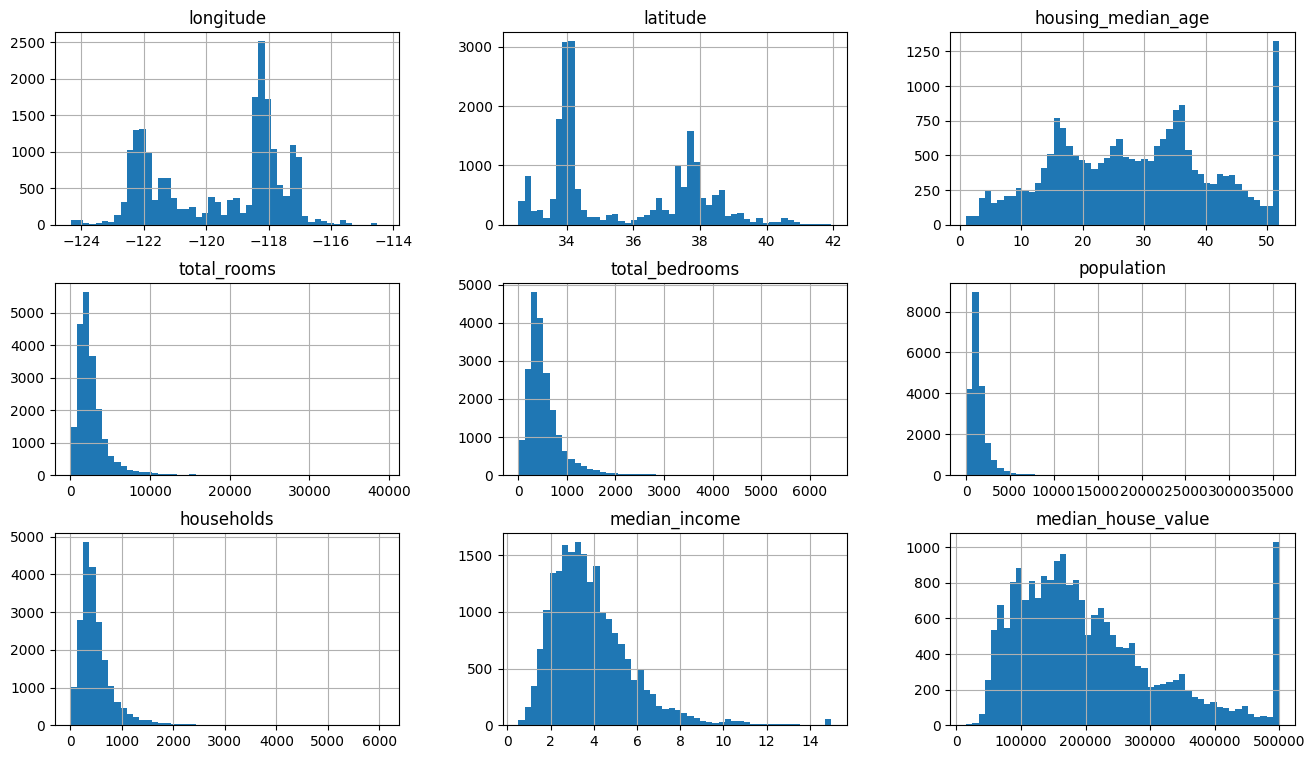

In [52]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(16, 9))
plt.show()

# Profiling: are there relationships between variables?

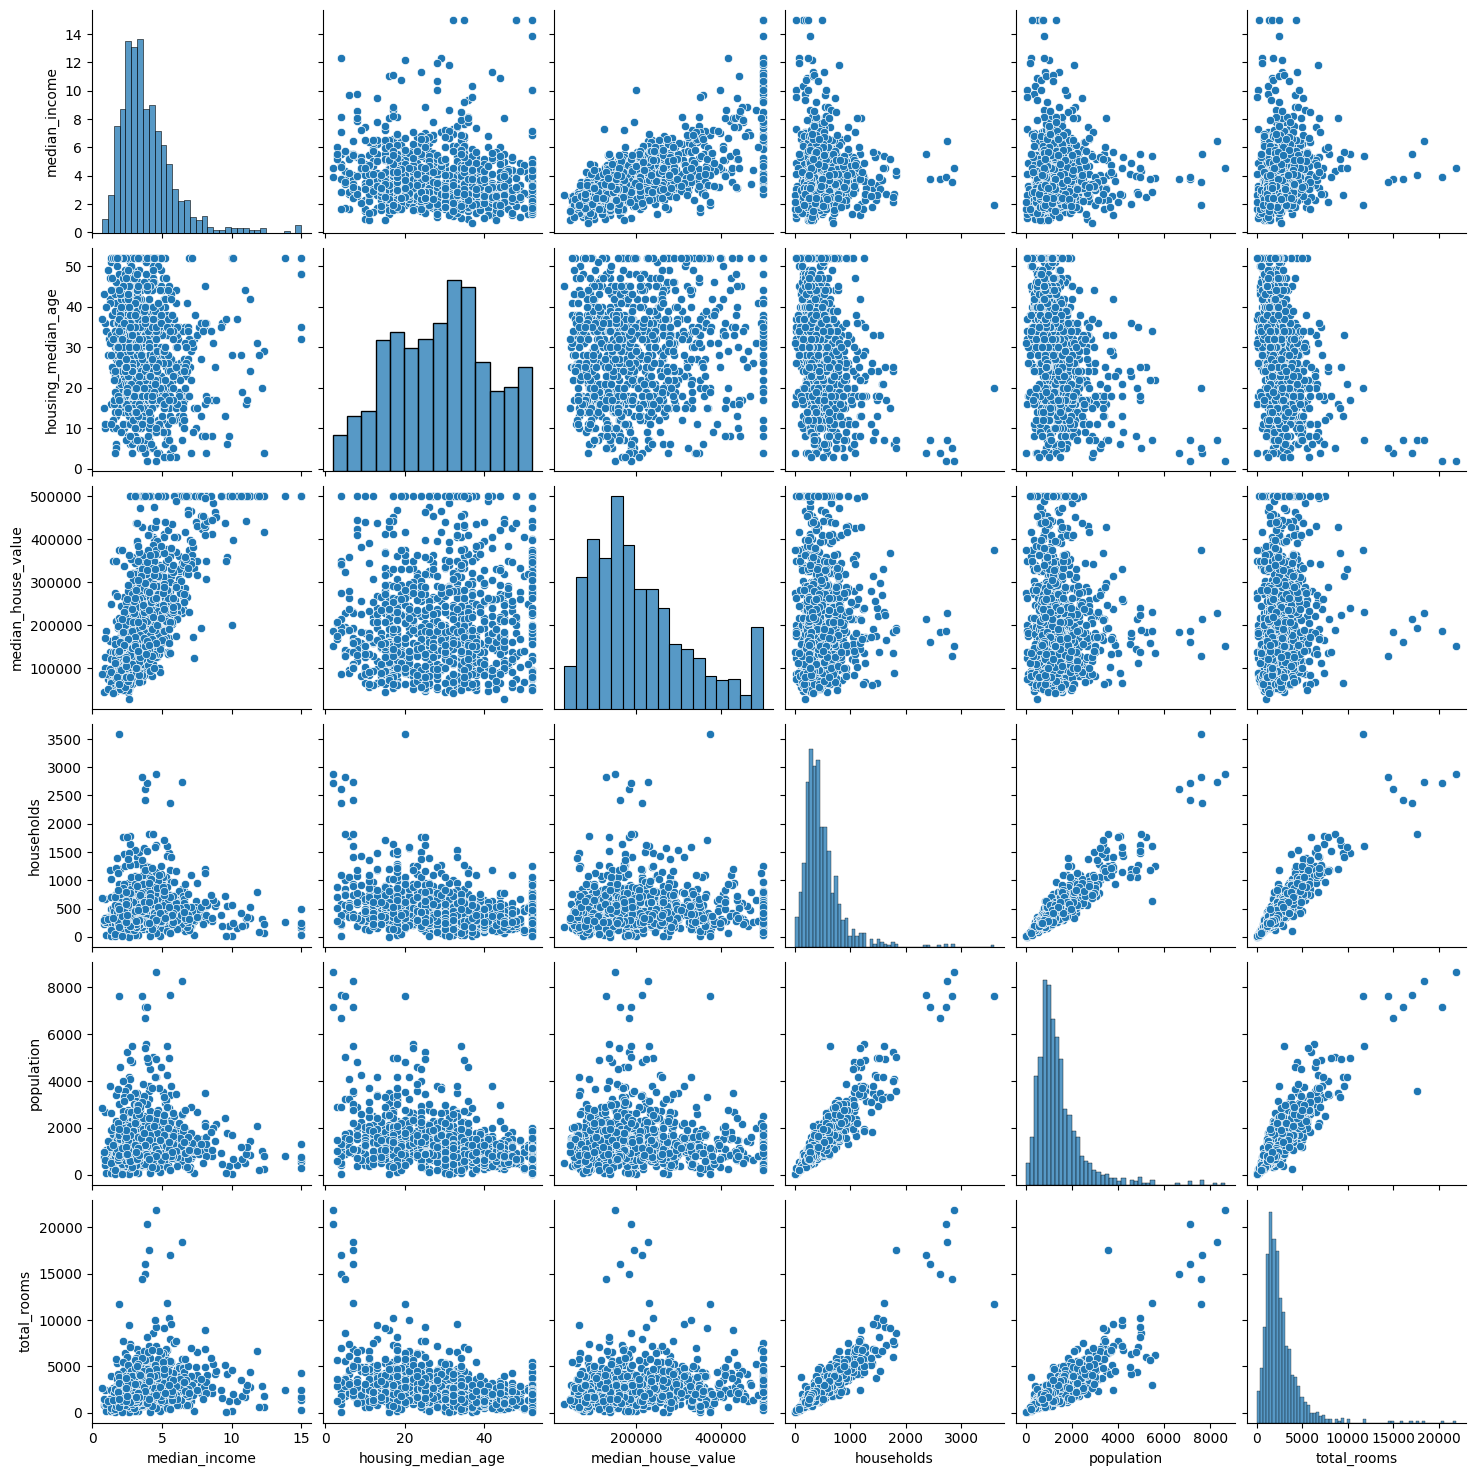

In [53]:
tmp = df[["median_income", "housing_median_age", "median_house_value", "households", "population", "total_rooms"]]
sns.pairplot(tmp.sample(n=1000, random_state=42), markers='o') # hue="median_house_value",
plt.show()

# Compression: Memory usage

What if I change float64 to float32?

In [17]:
dff = df.copy(deep=True) # copy the dataframe
for x in df.columns: # iterate over the columns
    if dff[x].dtype == 'float64': dff[x] = dff[x].astype('float32') # ... change it to `float32`
dff.info() # show some statistics on the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20433 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   median_house_value  20640 non-null  float32
 9   ocean_proximity     20640 non-null  object 
dtypes: float32(9), object(1)
memory usage: 887.0+ KB


# Compression: Memory usage

What if I change float64 to float16?

In [18]:
dff = df.copy(deep=True) # copy the dataframe
for x in df.columns: # iterate over the columns
    if dff[x].dtype == 'float64': dff[x] = dff[x].astype('float16') # ... change it to `float16`
dff.info() # show some statistics on the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float16
 1   latitude            20640 non-null  float16
 2   housing_median_age  20640 non-null  float16
 3   total_rooms         20640 non-null  float16
 4   total_bedrooms      20433 non-null  float16
 5   population          20640 non-null  float16
 6   households          20640 non-null  float16
 7   median_income       20640 non-null  float16
 8   median_house_value  20640 non-null  float16
 9   ocean_proximity     20640 non-null  object 
dtypes: float16(9), object(1)
memory usage: 524.2+ KB


e:\OneDrive - Alma Mater Studiorum Università di Bologna\teaching-bigdata\AA2425-unibo-bigdataandcloudplatforms\.venv\Lib\site-packages\pandas\core\dtypes\astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


#

In [19]:
dff.describe()

e:\OneDrive - Alma Mater Studiorum Università di Bologna\teaching-bigdata\AA2425-unibo-bigdataandcloudplatforms\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
e:\OneDrive - Alma Mater Studiorum Università di Bologna\teaching-bigdata\AA2425-unibo-bigdataandcloudplatforms\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
e:\OneDrive - Alma Mater Studiorum Università di Bologna\teaching-bigdata\AA2425-unibo-bigdataandcloudplatforms\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
e:\OneDrive - Alma Mater Studiorum Università di Bologna\teaching-bigdata\AA2425-unibo-bigdataandcloudplatforms\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarn

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2.064000e+04,2.064000e+04,2.064000e+04,20640.00,20433.0,20640.0,20640.0,2.064000e+04,20640.0
mean,-inf,inf,inf,inf,inf,inf,inf,inf,inf
std,2.003906e+00,2.136719e+00,1.258594e+01,inf,inf,inf,inf,1.899414e+00,NaN
min,-1.243750e+02,3.253125e+01,1.000000e+00,2.00,1.0,3.0,1.0,5.000000e-01,15000.0
25%,-1.218125e+02,3.393750e+01,1.800000e+01,1447.75,296.0,787.0,280.0,2.563965e+00,NaN
50%,-1.185000e+02,3.425000e+01,2.900000e+01,2128.00,435.0,1166.0,409.0,3.535156e+00,NaN
75%,-1.180000e+02,3.771875e+01,3.700000e+01,3148.00,647.0,1725.0,605.0,4.742188e+00,NaN
max,-1.143125e+02,4.193750e+01,5.200000e+01,39328.00,6444.0,35680.0,6080.0,1.500000e+01,inf


# Data preprocessing

# Missing values

There are some missing values in the column `total_bedorooms` what can we do?

Most Machine Learning algorithms cannot work with missing features. We have three options:

- Get rid of the corresponding districts (i.e., drop the rows)
- Get rid of the whole attribute (i.e., drop the columns)
- Set the values to some value (zero, the mean, the median, etc.)


# Non-numeric attributes

`ocean_proximity` is a text attribute so we cannot compute its median. Some options:

- Get rid of the whole attribute. (`df.drop("ocean_proximity", axis=1)`)
- Change from categorical to ordinal (e.g., `NEAR BAY` = 0, `INLAND` = 1)
- Change from categorical to one hot encoding

# Scaling attributes

Attributes have very different scales.

Should we scale them?

- Min-max normalization
- Standardization
- Robust scaling

# Machine learning

Our machine learning pipeline can be composed by alternative solutions

If we consider the default parameters for each algorithm, we have

- 3 options for imputation
- ... x 2 options for encoding
- ... x 3 options for normalization
- ... x 3 algorithms
- = 54 alternatives!

# Alternative pre-processing pipelines

In [55]:
from sklearn.preprocessing import StandardScaler

if "ocean_proximity" in df.columns:  # For now we simply drop "ocean_proximity"
  df = df.drop("ocean_proximity", axis=1)

# Let's create some dataset variations
# dataset1: drop the rows containing the null values and the columns `latitude` and `longitude`
dataset_v1 = df.copy(deep=True).dropna().drop(["longitude", "latitude"], axis=1)
# dataset2: impute missing values with the average number of bedrooms
dataset_v2 = df.copy(deep=True)
dataset_v2["total_bedrooms"] = dataset_v2["total_bedrooms"].fillna(dataset_v2["total_bedrooms"].mean())
# dataset3: also standardize dataset_v2
numerical_features = dataset_v2.select_dtypes(include=np.number)  # select numerical features
scaler = StandardScaler()  # Create a StandardScaler object
scaled_features = scaler.fit_transform(numerical_features)  # Fit and transform the numerical features
dataset_v3 = pd.DataFrame(scaled_features, columns=numerical_features.columns)  # Convert the scaled features back to a DataFrame

# Create the list of datasets
datasets = [(dataset_v1, "dataset_v1"), (dataset_v2, "dataset_v2"), (dataset_v3, "dataset_v3")]

# Alternative machine learning algorithms

In [56]:
# Let's import some machine learning models (here we are not addressing hyper-parameter tuning)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
dt_3 = DecisionTreeRegressor(random_state=0, max_depth=3)  # initialize decision tree regressor model
dt_5 = DecisionTreeRegressor(random_state=0, max_depth=5)  # initialize decision tree regressor model
lr = LinearRegression()  # initialize a linear regressor model
# Create the list of algorithms
ml_algorithms = [(lr, "lr"), (dt_3, "dt_3"), (dt_5, "dt_5")]

# Train the models

What are the insights?

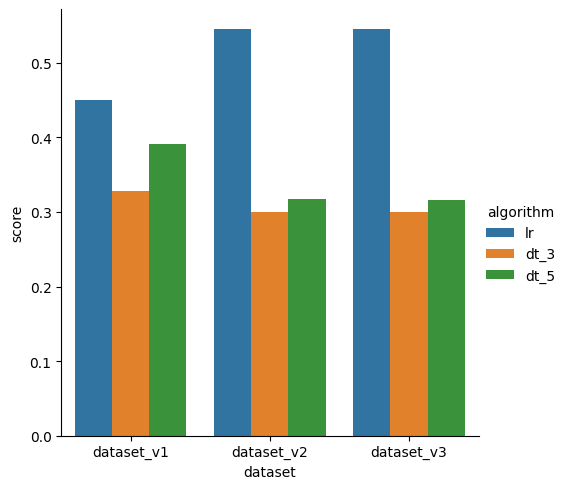

In [57]:
from sklearn.model_selection import cross_val_score
instances, i = [], 0
for dataset, dataset_version in datasets:  # For each dataset version...
  X = dataset.drop(columns=["median_house_value"]).to_numpy()  # Get the training set
  y = dataset["median_house_value"].to_numpy()  # Get the label array
  for ml_algorithm, ml_algorithm_version in ml_algorithms:  # For each machine learning algorithm...
    instance = {}  # Run the machine learning algorithm on the given dataset
    instance["id"] = i  # store the id of the instance
    instance["dataset"] = dataset_version  # store the version of the dataset
    instance["algorithm"] = ml_algorithm_version  # store the version of the ml algorithm
    instance["score"] = cross_val_score(ml_algorithm, X, y, cv=10).mean()  # store the performance of the pipeline instance
    instances = instances + [instance]
    i += 1
result = pd.DataFrame.from_dict(instances, orient='columns')  # Collect the results
sns.catplot(x = "dataset", y = "score", hue = "algorithm", data = result, kind = "bar")

# How do we track all these changes?

In [58]:
#| echo: false
#| output: false

!apt update -y
!apt install graphviz -y

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 2s (183 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
50 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Sk

# Creating and plotting the provenance graph

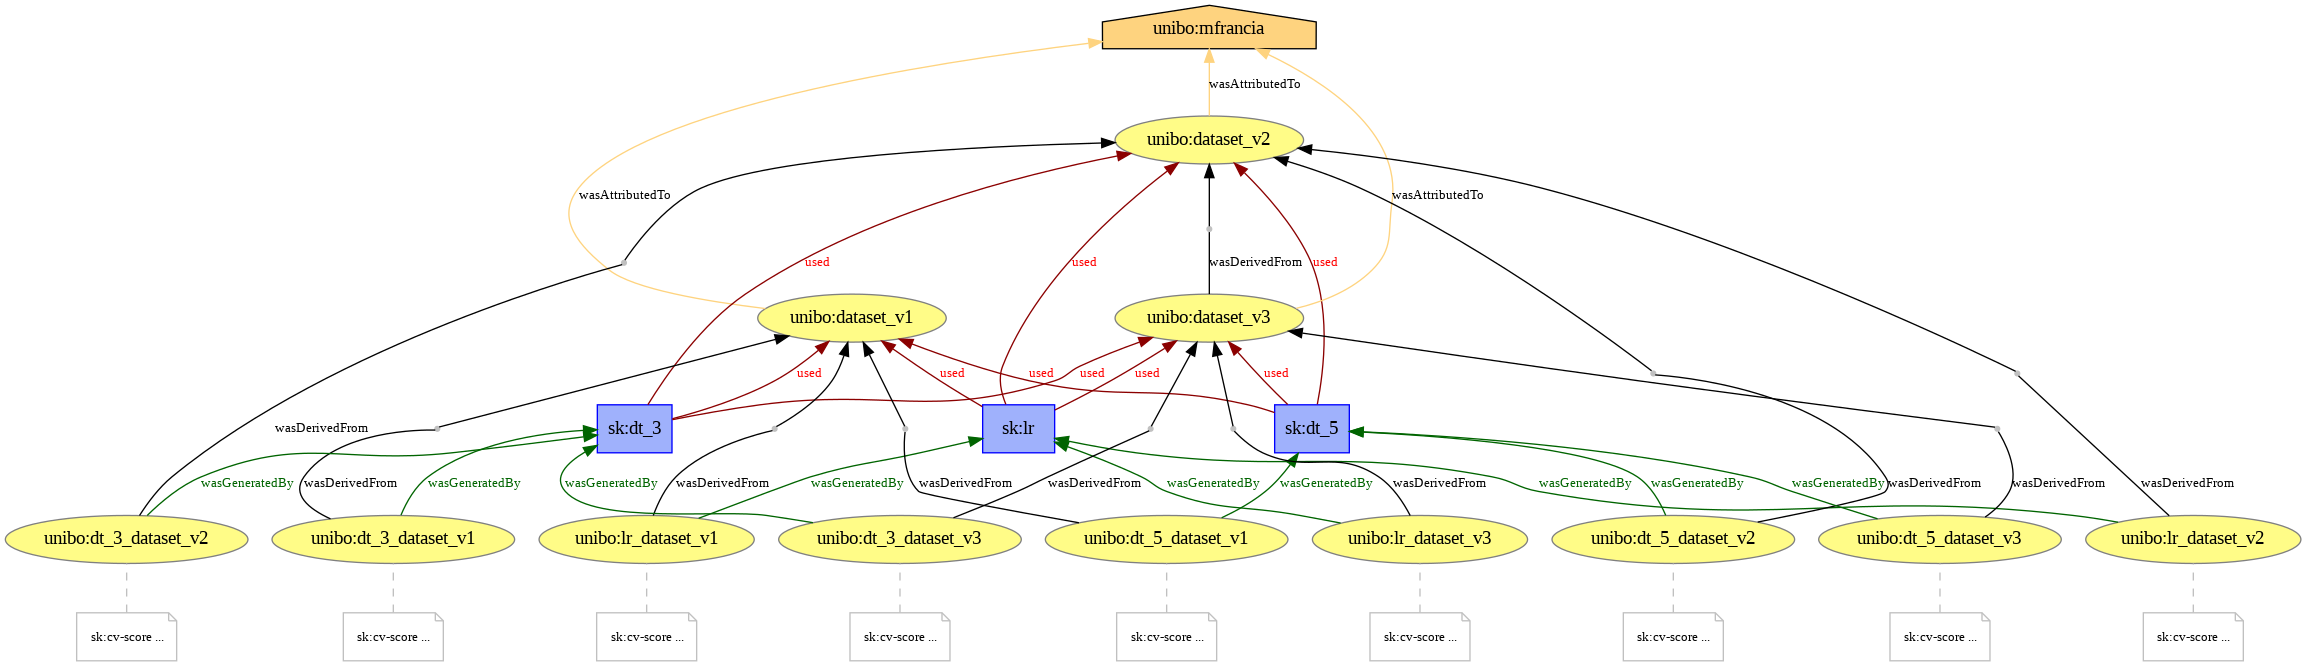

In [59]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image
d1 = ProvDocument()  # Create an empty provenance document
d1.add_namespace('unibo', 'https://www.unibo.it')  # add the namespace
d1.add_namespace('sk', 'https://scikit-learn.org/stable/')  # add the namespace
agent = d1.agent('unibo:mfrancia')  # add an agent
d1.wasDerivedFrom("unibo:dataset_v3", "unibo:dataset_v2")
for dataset, dataset_version in datasets:  # For each dataset version...
  original_dataset = d1.entity('unibo:' + dataset_version)  # register the dataset
  d1.wasAttributedTo(original_dataset, agent)  # attribute the dataset to the agent who created it
  for ml_algorithm, ml_algorithm_version in ml_algorithms:  # For each machine learning algorithm...
    algo = d1.activity('sk:' + ml_algorithm_version)  # register the algorithm as a (processing) activity
    processed_dataset = d1.entity('unibo:' + ml_algorithm_version + "_" + dataset_version, {'sk:cv-score': '...'})  # create an activity represented the processed dataset
    d1.used(algo, original_dataset)  # the activity used the dataset as input
    d1.wasGeneratedBy(processed_dataset, algo)  # the processed dataset has been created by the algorithm
    d1.wasDerivedFrom(processed_dataset, original_dataset)  # the processed dataset has been derived from the original one
dot = prov_to_dot(d1)  # visualize the graph
dot.write_png('prov.png')
Image('prov.png')

# Can you build and track a better model?

In [60]:
# Try your sk-learn model here